In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import PIL
import cv2
import torchvision.transforms as transforms
import PIL.Image
import glob

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import json
import trt_pose.coco
import timm
import time

with open('human_pose_2.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)
topology

tensor([[ 0,  1,  0,  1],
        [ 2,  3,  1,  2],
        [ 4,  5,  2,  3],
        [ 6,  7,  3,  4],
        [ 8,  9,  4,  5],
        [10, 11,  5,  6],
        [12, 13,  2,  4]], dtype=torch.int32)

In [3]:
import trt_pose.models

num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

model = trt_pose.models.efficientnet_b3_baseline_att(num_parts, 2 * num_links).cuda().eval()

In [4]:
model[0].efficientnet.conv_stem.weight[0, 0]

tensor([[ 0.0642,  0.0589, -0.0545],
        [ 0.1169, -0.2110, -0.4134],
        [ 0.1067,  0.0160, -0.1370]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [5]:
import torch
MODEL_WEIGHTS = 'epoch_50.pth'
state_dict = torch.load(MODEL_WEIGHTS)

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
    
model.load_state_dict(new_state_dict)    

<All keys matched successfully>

In [6]:
model[0].efficientnet.conv_stem.weight[0, 0]

tensor([[-0.0059, -0.0025,  0.2714],
        [-0.0583, -0.0256, -0.5492],
        [-0.0571, -0.1498,  0.2331]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [7]:
# import torch2trt
# WIDTH = 384
# HEIGHT = 384
# # data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()

# # model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)
# # model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=3000)

# OPTIMIZED_MODEL = './checkpoints/effi_epoch_180_trt.pth'
# # torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)

In [8]:
# from torch2trt import TRTModule

# model_trt = TRTModule()
# model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

In [10]:
# from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects
from draw import DrawObjects, SaveImage

parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)
save_image = SaveImage(topology)

In [13]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
device = torch.device('cuda')
SIZE = 224

# cap = cv2.VideoCapture('./video/video_sample_34_1.mp4')
cap = cv2.VideoCapture('./video/2person_35.h264')
# cap = cv2.VideoCapture('./video/out.mp4')
# cap = cv2.VideoCapture('./video/out_3.mp4')
# cap = cv2.VideoCapture('./video/out_3.h264')

pTime = 0
img_array = []
count = 0
while True :
    success, img = cap.read()

    if success == False :
        break

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (SIZE,SIZE), interpolation=cv2.INTER_NEAREST)
    
    image = resized_image / 255.
    image = (image - mean[None, None, :])/(std[None, None, :])
    # image = resized_image - np.array([123.675, 116.28,103.53], dtype=np.float32)[None, None, :]
    # image *= 0.0174292
    image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
    image = image.to(device)    
    
    # cmap, paf = model_trt(image[None, ...])
    cmap, paf = model(image[None, ...])
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)  
    if counts > 0 :
        break
    image = draw_objects(resized_image, counts, objects, peaks)
    img_array.append(image)

out = cv2.VideoWriter('./video/output.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, (SIZE, SIZE))
for i in range(len(img_array)) :
    out.write(img_array[i])
    
out.release()    


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [22]:
topology

tensor([[ 0,  1,  0,  1],
        [ 2,  3,  1,  2],
        [ 4,  5,  2,  3],
        [ 6,  7,  3,  4],
        [ 8,  9,  4,  5],
        [10, 11,  5,  6],
        [12, 13,  2,  4]], dtype=torch.int32)

In [17]:
objects.shape

torch.Size([1, 100, 7])

In [20]:
objects[0,:5,:]

tensor([[ 0,  1,  0, -1, -1, -1, -1],
        [-1,  0, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1,  0],
        [-1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

In [19]:
peaks.shape

torch.Size([1, 7, 100, 2])

In [34]:
print('done')

done


In [22]:
# ls '../../../images'

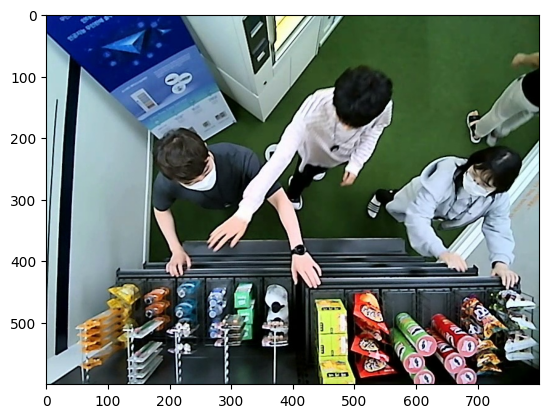

In [99]:
img = cv2.imread('../../../images/' + '694.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
# plt.show()

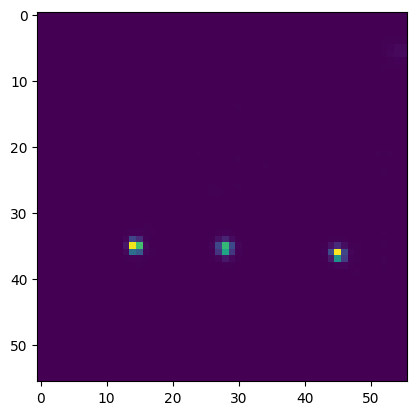

In [102]:
plt.imshow(cmap[0,0,:,:,])

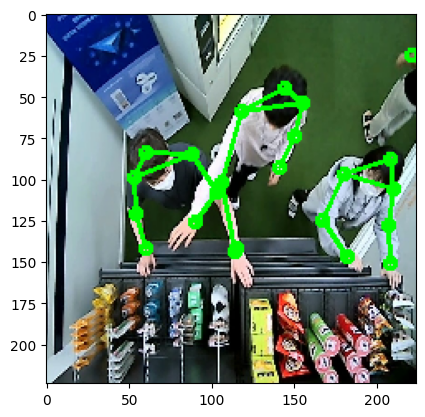

In [93]:
img = cv2.imread('../../../images/' + '694.jpg')
SIZE = 224
resized_image = cv2.resize(img, (SIZE,SIZE), interpolation=cv2.INTER_NEAREST)
image = resized_image / 255.
image = (image - mean[None, None, :])/(std[None, None, :])

image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
image = image.to(device)   

cmap, paf = model(image[None, ...])
cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
counts, objects, peaks = parse_objects(cmap, paf)  
image = draw_objects(resized_image, counts, objects, peaks)
plt.imshow(image)

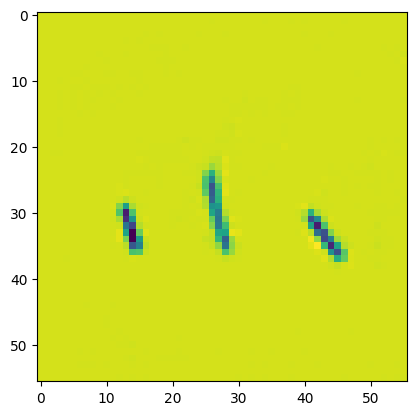

In [98]:
plt.imshow(paf[0,0,:,:,])

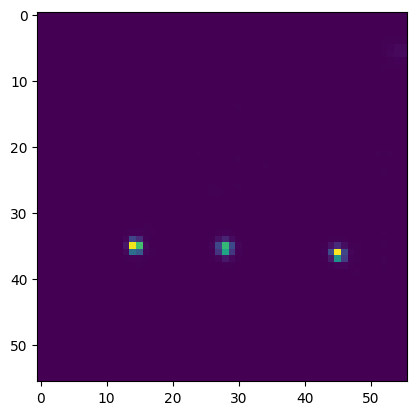

In [84]:
plt.imshow(cmap[0,0,:,:,])

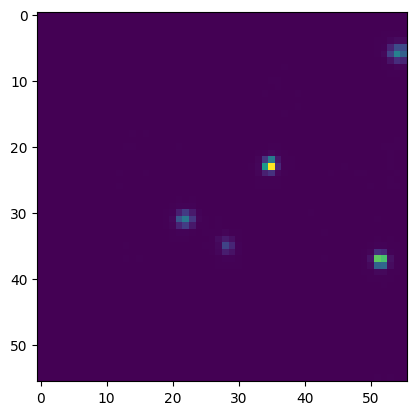

In [85]:
plt.imshow(cmap[0,6,:,:,])

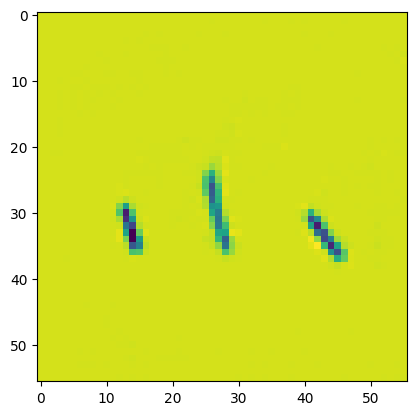

In [86]:
plt.imshow(paf[0,0,:,:,])

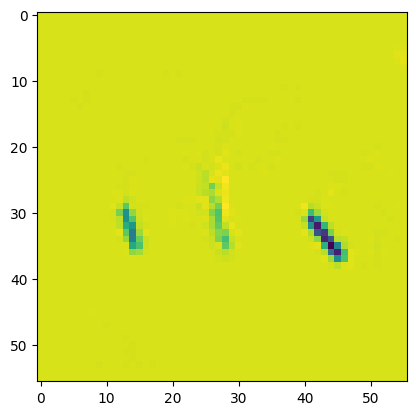

In [87]:
plt.imshow(paf[0,1,:,:,])

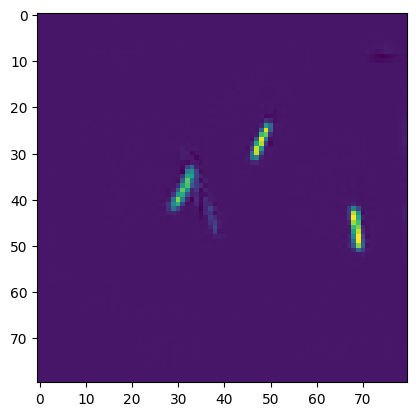

In [91]:
plt.imshow(paf[0,10,:,:,])

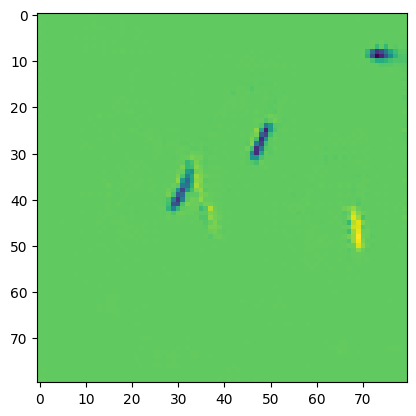

In [92]:
plt.imshow(paf[0,11,:,:,])